<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Chemical-Data" data-toc-modified-id="Import-Chemical-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Chemical Data</a></span></li><li><span><a href="#EGO-utilities" data-toc-modified-id="EGO-utilities-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EGO utilities</a></span></li><li><span><a href="#Examples" data-toc-modified-id="Examples-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Examples</a></span></li></ul></div>

# EGO decompositions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import networkx as nx
import toolz as tz
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger, verbosity=1)
import matplotlib.pyplot as plt
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

## Import Chemical Data

In [2]:
from toolz import curry, pipe
from eden_chem.io.pubchem import download
from eden_chem.io.rdkitutils import sdf_to_nx

download_active = curry(download)(active=True)
download_inactive = curry(download)(active=False)

def get_pos_graphs(assay_id): return pipe(assay_id, download_active, sdf_to_nx, list)
def get_neg_graphs(assay_id): return pipe(assay_id, download_inactive, sdf_to_nx, list)

from constrActive.utils import pre_process, _random_sample
from eden_chem.io.pubchem import get_assay_description

def make_data(assay_id, max_size=20):
    logger.debug('_'*80)
    logger.debug('Dataset %s info:'%assay_id)
    desc = get_assay_description(assay_id)
    logging.debug('\n%s'%desc)
    # extract pos and neg graphs
    all_pos_graphs, all_neg_graphs = get_pos_graphs(assay_id), get_neg_graphs(assay_id)
    # remove too large and too small graphs and outliers
    initial_max_size=2000
    initial_max_size=max(initial_max_size,max_size)
    args=dict(initial_max_size=initial_max_size, fraction_to_remove=.1, n_neighbors_for_outliers=9, remove_similar=False, max_size=max_size)
    logging.debug('\nPositive graphs')
    pos_graphs = pre_process(all_pos_graphs, **args)
    logging.debug('\nNegative graphs')
    neg_graphs = pre_process(all_neg_graphs, **args)
    logger.debug('-'*80)
    return pos_graphs, neg_graphs

## EGO utilities

In [3]:
from ego.vectorize import set_feature_size
from ego.encode import make_encoder
from ego.decompose import concatenate, compose

from ego.path import decompose_path
from ego.cycle_basis import decompose_cycles_and_non_cycles, decompose_non_cycles, decompose_cycles
from ego.iterated_clique import decompose_iterated_clique
from ego.context import decompose_context
from ego.dilatate import decompose_dilatate
from ego.paired_neighborhoods import decompose_paired_neighborhoods, decompose_neighborhood
from ego.centrality import decompose_central_and_non_central, decompose_central, decompose_non_central
from ego.discriminative import decompose_discriminative_and_non_discriminative, decompose_discriminative, decompose_non_discriminative


from ego.abstract_label import preprocess_abstract_label
from ego.minor_graph import preprocess_minor_degree

In [4]:
from GraphDesign.utils import draw_mols
from collections import defaultdict

def select_unique(codes, fragments):
    already_seen = set()
    unique_codes=[]
    unique_fragments=[]
    code_counts = defaultdict(int)
    for code, fragment in zip(codes, fragments):
        if code not in already_seen:
            unique_codes.append(code)
            unique_fragments.append(fragment)
            already_seen.add(code)
        code_counts[code] += 1
    return unique_codes, unique_fragments, code_counts


def show_decomposition_graphs(graphs, decompose_funcs, preprocessors=None, nbits=14):
    feature_size, bitmask = set_feature_size(nbits=nbits)
    encoding_func = make_encoder(decompose_funcs, preprocessors=preprocessors, bitmask=bitmask, seed=1)
    for g in graphs:
        print('_'*120)
        draw_mols([g])
        codes, fragments = encoding_func(g)
        unique_codes, unique_fragments, code_counts = select_unique(codes, fragments)
        titles = ['%d   #%d'%(id,code_counts[id]) for id in unique_codes]
        #titles = list(map(str, unique_codes))
        print('%d unique components in %d fragments'%(len(unique_codes),len(codes)))
        if unique_fragments:
            draw_mols(unique_fragments, titles, n_graphs_per_line=9)
        else:
            print('No fragments')

## Examples

In [5]:
%%time
assay_ids = ['624249']
assay_id=assay_ids[0]
configure_logging(logger, verbosity=2)
pos_graphs, neg_graphs = make_data(assay_id, max_size=300)
configure_logging(logger, verbosity=1)

________________________________________________________________________________
Dataset 624249 info:

qHTS screen for small molecules that inhibit ELG1-dependent DNA repair in human embryonic kidney (HEK293T) cells expressing luciferase-tagged ELG1: Hit Confirmation using MMS Stimulated ELG1
Reading from file: PUBCHEM/AID624249_active.sdf
Reading from file: PUBCHEM/AID624249_inactive.sdf

Positive graphs
original size:355
random sample:355
removed disconnected:339
size filter:322
outlier removal:257
random sample:257

Negative graphs
original size:173
random sample:173
removed disconnected:170
size filter:161
outlier removal:134
random sample:134
--------------------------------------------------------------------------------
CPU times: user 7.66 s, sys: 88 ms, total: 7.75 s
Wall time: 7.74 s


In [6]:
from ego.discriminate import Discriminator
from sklearn.metrics import roc_auc_score

def make_data_split(pos_graphs, neg_graphs, test_frac=.3):
    test_set_size = int(len(pos_graphs)*test_frac)
    test_pos_graphs = pos_graphs[:test_set_size]
    train_pos_graphs = pos_graphs[test_set_size:]
    test_set_size = int(len(neg_graphs)*test_frac)
    test_neg_graphs = neg_graphs[:test_set_size]
    train_neg_graphs = neg_graphs[test_set_size:]
    train_graphs=train_pos_graphs+train_neg_graphs
    train_target=[1]*len(train_pos_graphs)+[-1]*len(train_neg_graphs)
    test_graphs=test_pos_graphs+test_neg_graphs
    test_target=[1]*len(test_pos_graphs)+[-1]*len(test_neg_graphs)
    return train_graphs, train_target, test_graphs, test_target

def eval_EDeN(pos_graphs, neg_graphs):
    from sklearn.linear_model import SGDClassifier
    from eden.graph import vectorize as eden_vectorize
    train_graphs, train_target, test_graphs, test_target = make_data_split(pos_graphs, neg_graphs, test_frac=.3)
    train_x = eden_vectorize(train_graphs, r=3,d=6)
    test_x = eden_vectorize(test_graphs, r=3,d=6)
    estimator = SGDClassifier(penalty='elasticnet', tol=1e-3)
    estimator.fit(train_x, train_target)
    preds = estimator.decision_function(test_x)
    return roc_auc_score(test_target, preds)

def eval_order0(pos_graphs, neg_graphs, decompose_func):
    train_graphs, train_target, test_graphs, test_target = make_data_split(pos_graphs, neg_graphs, test_frac=.3)
    disc = Discriminator(decompose_func=decompose_func, preprocessor=None, nbits=14)
    disc.fit(train_graphs, train_target)
    preds = disc.decision_function(test_graphs)
    return roc_auc_score(test_target, preds)

from ego.learn import make_node_scoring_func
def eval_order1(pos_graphs, neg_graphs, decompose_func):
    train_graphs, train_target, test_graphs, test_target = make_data_split(pos_graphs, neg_graphs, test_frac=.3)
    node_scoring_func = make_node_scoring_func(train_graphs, train_target, decomposition_funcs=decompose_func)
    
    f1 = decompose_discriminative(min_size=3, max_size=30, node_scoring_func=node_scoring_func, threshold=0.2)
    f2 = decompose_discriminative(min_size=3, max_size=30, node_scoring_func=node_scoring_func, threshold=0.4)
    f3 = decompose_discriminative(min_size=3, max_size=30, node_scoring_func=node_scoring_func, threshold=0.8)
    g1 = compose(decompose_iterated_clique(n_iter=2),decompose_cycles_and_non_cycles,f1)
    g2 = compose(decompose_iterated_clique(n_iter=2),decompose_cycles_and_non_cycles,f2)
    g3 = compose(decompose_iterated_clique(n_iter=2),decompose_cycles_and_non_cycles,f3)
    decompose_func2 = concatenate(g1,g2,g3)

    disc = Discriminator(decompose_func=[decompose_func, decompose_func2], preprocessor=None, nbits=14)
    disc.fit(train_graphs, train_target)
    preds = disc.decision_function(test_graphs)
    return roc_auc_score(test_target, preds)

def eval_order2(pos_graphs, neg_graphs, decompose_func):
    train_graphs, train_target, test_graphs, test_target = make_data_split(pos_graphs, neg_graphs, test_frac=.3)
    node_scoring_func = make_node_scoring_func(train_graphs, train_target, decomposition_funcs=decompose_func)
    f1 = decompose_discriminative(min_size=3, max_size=30, node_scoring_func=node_scoring_func, threshold=0.2)
    f2 = decompose_discriminative(min_size=3, max_size=30, node_scoring_func=node_scoring_func, threshold=0.4)
    f3 = decompose_discriminative(min_size=3, max_size=30, node_scoring_func=node_scoring_func, threshold=0.8)
    g1 = compose(decompose_iterated_clique(n_iter=2),decompose_cycles_and_non_cycles,f1)
    g2 = compose(decompose_iterated_clique(n_iter=2),decompose_cycles_and_non_cycles,f2)
    g3 = compose(decompose_iterated_clique(n_iter=2),decompose_cycles_and_non_cycles,f3)
    decompose_func2 = concatenate(g1,g2,g3)
    node_scoring_func2 = make_node_scoring_func(train_graphs, train_target, decomposition_funcs=decompose_func2)
    f12 = decompose_discriminative(min_size=3, max_size=30, node_scoring_func=node_scoring_func2, threshold=0.2)
    f22 = decompose_discriminative(min_size=3, max_size=30, node_scoring_func=node_scoring_func2, threshold=0.4)
    f32 = decompose_discriminative(min_size=3, max_size=30, node_scoring_func=node_scoring_func2, threshold=0.8)
    g12 = compose(decompose_iterated_clique(n_iter=2),decompose_cycles_and_non_cycles,f12)
    g22 = compose(decompose_iterated_clique(n_iter=2),decompose_cycles_and_non_cycles,f22)
    g32 = compose(decompose_iterated_clique(n_iter=2),decompose_cycles_and_non_cycles,f32)
    decompose_func3 = concatenate(g12,g22,g32)
    
    disc = Discriminator(decompose_func=[decompose_func, decompose_func2, decompose_func3], preprocessor=None, nbits=14)
    disc.fit(train_graphs, train_target)
    preds = disc.decision_function(test_graphs)
    return roc_auc_score(test_target, preds)


In [7]:
f1 = decompose_path(length=4)
f2 = decompose_cycles
f3 = concatenate(f1,f2)
decompose_func = compose(decompose_iterated_clique(n_iter=3, min_n_iter=1), f3)

In [8]:
f1 = decompose_paired_neighborhoods(radius=1, distance=3)
f2 = decompose_paired_neighborhoods(radius=1, distance=4)
f3 = decompose_paired_neighborhoods(radius=2, distance=5)
f4 = decompose_paired_neighborhoods(radius=2, distance=6)
f5 = compose(decompose_iterated_clique(n_iter=2, min_n_iter=1),decompose_cycles_and_non_cycles)
decompose_func = concatenate(f1,f2,f3,f4,f5)

In [9]:
f1 = decompose_neighborhood(radius=2)
f2 = decompose_paired_neighborhoods(radius=1, distance=4)
f3 = compose(
    decompose_iterated_clique(n_iter=1),
    decompose_cycles_and_non_cycles)
decompose_func = concatenate(f1,f2, f3)

In [10]:
assay_ids = ['624249']
for assay_id in assay_ids:
    configure_logging(logger, verbosity=2)
    pos_graphs, neg_graphs = make_data(assay_id, max_size=1000)
    configure_logging(logger, verbosity=1)
    
    try:
        %time print('EDeN AUC %.3f' % eval_EDeN(pos_graphs, neg_graphs))
        %time print('L0 AUC %.3f' % eval_order0(pos_graphs, neg_graphs, decompose_func))
        %time print('L1 AUC %.3f' % eval_order1(pos_graphs, neg_graphs, decompose_func))
        %time print('L2 AUC %.3f' % eval_order2(pos_graphs, neg_graphs, decompose_func))
        print
    except Exception as e:
        pass

________________________________________________________________________________
Dataset 624249 info:

qHTS screen for small molecules that inhibit ELG1-dependent DNA repair in human embryonic kidney (HEK293T) cells expressing luciferase-tagged ELG1: Hit Confirmation using MMS Stimulated ELG1
Reading from file: PUBCHEM/AID624249_active.sdf
Reading from file: PUBCHEM/AID624249_inactive.sdf

Positive graphs
original size:355
random sample:355
removed disconnected:339
size filter:322
outlier removal:257
random sample:257

Negative graphs
original size:173
random sample:173
removed disconnected:170
size filter:161
outlier removal:134
random sample:134
--------------------------------------------------------------------------------
EDeN AUC 0.760
CPU times: user 10.3 s, sys: 140 ms, total: 10.4 s
Wall time: 9.03 s
L0 AUC 0.736
CPU times: user 56.7 s, sys: 1.16 s, total: 57.8 s
Wall time: 51.7 s
L1 AUC 0.665
CPU times: user 4min 33s, sys: 2.9 s, total: 4min 36s
Wall time: 4min 28s
L2 AUC 0.6

---

In [15]:
graphs = pos_graphs + neg_graphs
targets = np.array([1]*len(pos_graphs) + [-1]*len(neg_graphs)).reshape(-1)

In [16]:
import random
random.shuffle(pos_graphs)
gs = pos_graphs[0:1]

________________________________________________________________________________________________________________________


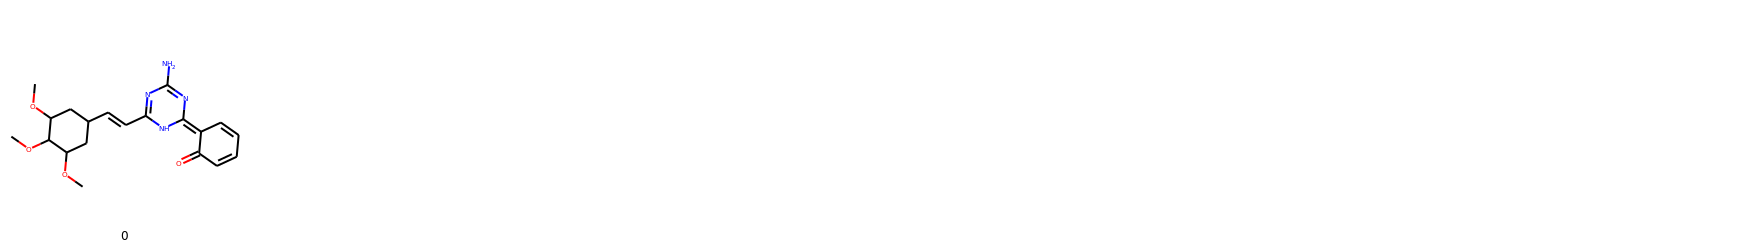

62 unique components in 133 fragments


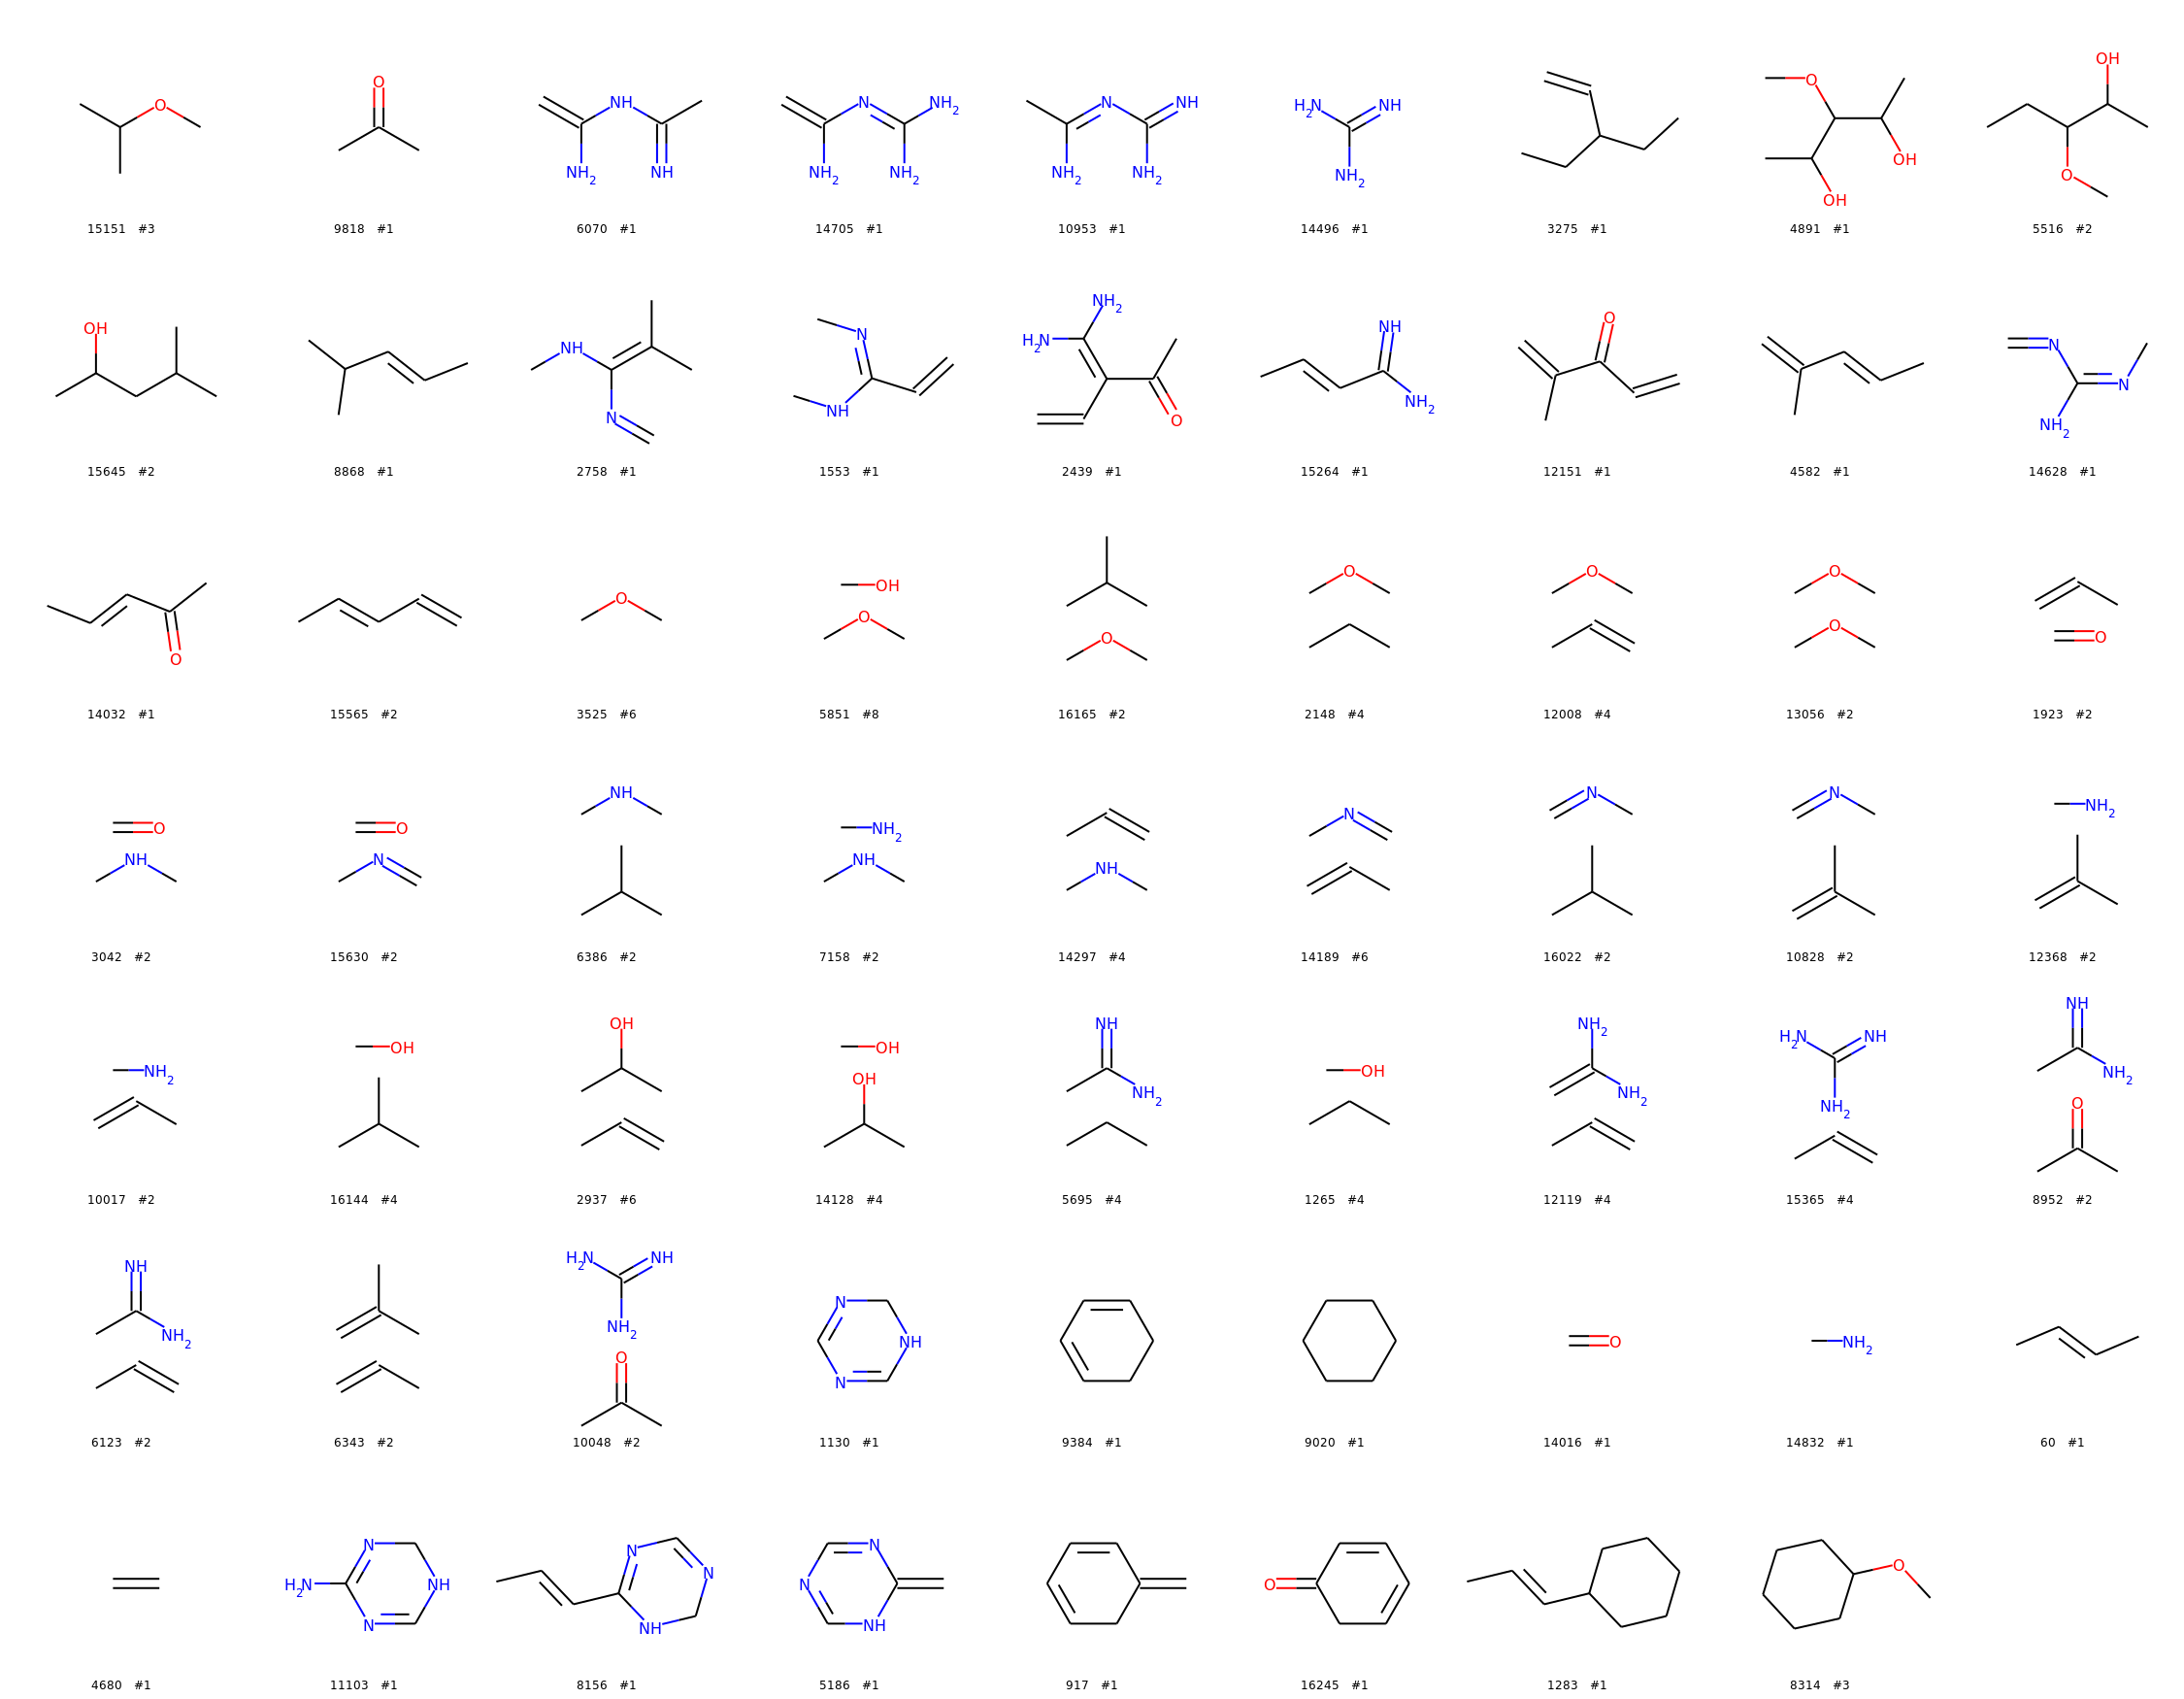

In [ ]:
show_decomposition_graphs(gs, decompose_func)

In [ ]:
from ego.learn import make_node_scoring_func
node_scoring_func = make_node_scoring_func(graphs, targets, decomposition_funcs=decompose_func)

In [ ]:
decompose_func = decompose_discriminative(min_size=3, max_size=30, node_scoring_func=node_scoring_func, threshold=0.5)
show_decomposition_graphs(gs, decompose_func)

In [ ]:
decompose_func = decompose_non_discriminative(min_size=3, max_size=30, node_scoring_func=node_scoring_func, threshold=0.5)
show_decomposition_graphs(gs, decompose_func)

In [ ]:
f1 = decompose_discriminative(min_size=3, max_size=30, node_scoring_func=node_scoring_func, threshold=0.2)
f2 = decompose_discriminative(min_size=3, max_size=30, node_scoring_func=node_scoring_func, threshold=0.4)
f3 = decompose_discriminative(min_size=3, max_size=30, node_scoring_func=node_scoring_func, threshold=0.8)
decompose_func = concatenate(f1,f2,f3)
show_decomposition_graphs(gs, decompose_func)

In [ ]:
f1 = decompose_discriminative(min_size=3, max_size=30, node_scoring_func=node_scoring_func, threshold=0.2)
f2 = decompose_discriminative(min_size=3, max_size=30, node_scoring_func=node_scoring_func, threshold=0.4)
f3 = decompose_discriminative(min_size=3, max_size=30, node_scoring_func=node_scoring_func, threshold=0.8)
decompose_func = compose(
    decompose_iterated_clique(n_iter=2),
    decompose_cycles_and_non_cycles,
    concatenate(f1,f2,f3))
show_decomposition_graphs(gs, decompose_func)

In [ ]:
decompose_func2 = compose(
    decompose_iterated_clique(n_iter=1),
    decompose_cycles_and_non_cycles,
    decompose_discriminative(min_size=3, max_size=30, node_scoring_func=node_scoring_func, threshold=0.5))
show_decomposition_graphs(gs, decompose_func2)

In [ ]:
from ego.learn import make_node_scoring_func
node_scoring_func2 = make_node_scoring_func(graphs, targets, decomposition_funcs=decompose_func2)

In [ ]:
decompose_func3 = compose(
    decompose_iterated_clique(n_iter=1),
    decompose_cycles_and_non_cycles,
    decompose_discriminative(min_size=3, max_size=50, node_scoring_func=node_scoring_func2, threshold=0.5))
show_decomposition_graphs(gs, decompose_func3)

---